# Лекция 1: Токенизация, морфология, синтаксис и семантика

В этом ноутбуке показаны 4 этапа NLP с простыми и практичными примерами.

In [ ]:
# Установка библиотек (выполнить один раз)
!pip install -q spacy razdel pymorphy3 tiktoken pandas matplotlib networkx scikit-learn gensim
# !python -m spacy download ru_core_news_md

In [ ]:
# !uv run python -m spacy download ru_core_news_md # TODO: Only for uv users

In [44]:
import re
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pymorphy3
import spacy
import tiktoken
from IPython.display import display
from razdel import sentenize, tokenize
from spacy import displacy

nlp = spacy.load("ru_core_news_md")
morph = pymorphy3.MorphAnalyzer()

""" Загружено """

' Загружено '

## 1) Пример токенизации

**Что это:** разбиение текста на предложения и токены.

**Библиотеки:** `razdel`, `spaCy`, `nltk`; для GPT-токенов — `tiktoken`.

In [45]:
# https://github.com/natasha/razdel

In [46]:
text = """
Анна написала статью про экотуризм.
Иван подготовил обзор по цифровой экономике.
Анна взяла еще одну тему: применение ИИ в медицине.
""".strip()

sentences = [s.text for s in sentenize(text)]
tokens = [t.text for t in tokenize(text)]

print("Предложения:")
for i, s in enumerate(sentences, 1):
    print(f"{i}. {s}")
print("\nПервые токены:", tokens[:20])
print("Всего токенов:", len(tokens))

Предложения:
1. Анна написала статью про экотуризм.
2. Иван подготовил обзор по цифровой экономике.
3. Анна взяла еще одну тему: применение ИИ в медицине.

Первые токены: ['Анна', 'написала', 'статью', 'про', 'экотуризм', '.', 'Иван', 'подготовил', 'обзор', 'по', 'цифровой', 'экономике', '.', 'Анна', 'взяла', 'еще', 'одну', 'тему', ':', 'применение']
Всего токенов: 24


In [47]:
# Как можно использовать дальше: подсчет предложений по автору
examples = [
    {"author": "Анна", "text": "Сегодня обсуждаем машинное обучение. Потом разбираем примеры."},
    {"author": "Иван", "text": "Я собрал данные. Построил графики. Сделал выводы."},
    {"author": "Анна", "text": "Добавила блок про риски внедрения ИИ."},
    {"author": "Мария", "text": "Подготовила слайды. Проверила источники."}
]

rows = []
for row in examples:
    rows.append({
        "author": row["author"],
        "sentence_count": len(list(sentenize(row["text"]))),
        "token_count": len(list(tokenize(row["text"])))
    })

df = pd.DataFrame(rows)
summary = df.groupby("author", as_index=False).sum().sort_values("sentence_count", ascending=False)
display(df)
display(summary)

,author,sentence_count,token_count
0,Анна,2,9
1,Иван,3,10
2,Анна,1,7
3,Мария,2,6


,author,sentence_count,token_count
0,Анна,3,16
1,Иван,3,10
2,Мария,2,6


**Практическое применение:**
- Анализ учебных работ: кто пишет кратко, кто подробно
- Контроль качества контента в медиа/редакции
- Подготовка данных для чат-ботов и классификаторов

In [48]:
# В GPT токен - более мелкая единица, чем слово
phrase = "Нейросети помогают анализировать тексты быстрее."
enc = tiktoken.get_encoding("cl100k_base")
token_ids = enc.encode(phrase)
pieces = [enc.decode([tid]) for tid in token_ids]

print("Фраза:", phrase)
print("GPT-токенов:", len(token_ids))
print("Первые ID:", token_ids[:15])
print("Первые фрагменты:", pieces[:15])

Фраза: Нейросети помогают анализировать тексты быстрее.
GPT-токенов: 21
Первые ID: [20807, 21708, 42057, 8341, 1840, 76401, 14837, 1506, 70129, 21022, 14525, 11320, 9136, 59921, 18482]
Первые фрагменты: ['Н', 'ей', 'рос', 'ет', 'и', ' пом', 'ог', 'а', 'ют', ' а', 'на', 'ли', 'з', 'иров', 'ать']


**Зачем GPT-токенизация:**
- Модель работает с кусочками текста, включая части слов
- Это помогает обрабатывать редкие слова и новые термины
- Ограничения контекста и стоимость API считаются в токенах

In [49]:
# https://github.com/openai/tiktoken 

# также помогает оптимизировать скорость обработки и уменьшить вес.

## 2) Морфологический анализ

**Что это:** определение леммы и грамматических признаков слова.

In [50]:
simple_sentences = [
    "Машинное обучение это круто.",
    "Автоваз: можно, а зачем?"
]
complex_sentence = "Когда начался дождь, студенты быстро перешли в библиотеку и продолжили обсуждение проекта."

def show_morph(sentence):
    print(f"\nПредложение: {sentence}")
    words = re.findall(r"[А-Яа-яA-Za-zЁё-]+", sentence)
    for w in words:
        p = morph.parse(w)[0]
        print(f"{w:15} | lemma_={p.normal_form:15} | POS={p.tag.POS:10} | {p.tag}")

for s in simple_sentences:
    show_morph(s)
show_morph(complex_sentence)


Предложение: Машинное обучение это круто.
Машинное        | lemma_=машинный        | POS=ADJF       | ADJF,Qual neut,sing,nomn
обучение        | lemma_=обучение        | POS=NOUN       | NOUN,inan,neut sing,nomn
это             | lemma_=это             | POS=PRCL       | PRCL
круто           | lemma_=круто           | POS=ADVB       | ADVB

Предложение: Автоваз: можно, а зачем?
Автоваз         | lemma_=автоваз         | POS=NOUN       | NOUN,inan,masc,Orgn sing,nomn
можно           | lemma_=можно           | POS=PRED       | PRED,pres
а               | lemma_=а               | POS=CONJ       | CONJ
зачем           | lemma_=зачем           | POS=ADVB       | ADVB,Ques,Prdx

Предложение: Когда начался дождь, студенты быстро перешли в библиотеку и продолжили обсуждение проекта.
Когда           | lemma_=когда           | POS=CONJ       | CONJ
начался         | lemma_=начаться        | POS=VERB       | VERB,perf,intr masc,sing,past,indc
дождь           | lemma_=дождь           | POS=NOUN  

**Практическое применение:**
- Поиск по леммам: `купил`, `куплю`, `купить` как одна группа
- Анализ обращений: удобнее группировать похожие жалобы
- Проверка качества текстов (грубые грамматические аномалии)

In [51]:
# примеры https://pymorphy2.readthedocs.io/en/0.4/user/guide.html#:~:text=tag.POS%20%23%20Part%20of%20Speech%2C%20часть%20речи,включенность%20говорящего%20в%20действие%20None%20%3E%3E%3E%20p.tag.


## 3) Синтаксический анализ

**Что это:** определение связей слов в предложении (кто сделал, что сделал, с чем связано).

In [52]:
syntax_text = "Студент внимательно изучил новую тему и объяснил решение одногруппникам."
doc = nlp(syntax_text)

print("Связи token <- head:")
for t in doc:
    print(f"{t.text:15} <- {t.head.text:15} | dep={t.dep_}")

Связи token <- head:
Студент         <- изучил          | dep=nsubj
внимательно     <- изучил          | dep=advmod
изучил          <- изучил          | dep=ROOT
новую           <- тему            | dep=amod
тему            <- изучил          | dep=obj
и               <- объяснил        | dep=cc
объяснил        <- изучил          | dep=conj
решение         <- объяснил        | dep=obj
одногруппникам  <- объяснил        | dep=iobj
.               <- изучил          | dep=punct


In [53]:
# Готовое дерево зависимостей
displacy.render(doc, style="dep", jupyter=True, options={"distance": 95})

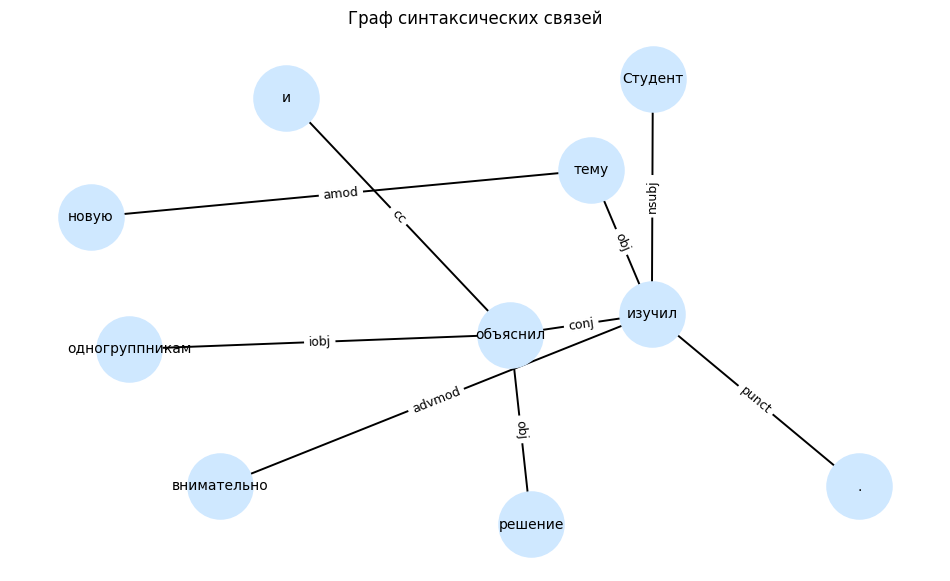

In [54]:
# Граф связей через networkx
G = nx.DiGraph()
for t in doc:
    G.add_node(t.text)
    if t.head != t:
        G.add_edge(t.head.text, t.text, label=t.dep_)

plt.figure(figsize=(12, 7))
pos = nx.spring_layout(G, seed=42, k=1.2)
nx.draw_networkx_nodes(G, pos, node_size=2200, node_color="#CFE8FF")
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="->", arrowsize=18, width=1.4)
edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
plt.title("Граф синтаксических связей")
plt.axis("off")
plt.show()

**Практическое применение:**
- В поддержке: извлекать суть жалобы (`кто` + `какая проблема`)
- В документах: точнее выделять факты и действия
- В обучении: наглядно объяснять структуру сложных предложений

## 4) Как делается семантический анализ

Один из базовых подходов — сравнение смысловой близости фраз через векторные представления (эмбеддинги).

In [55]:
pairs = [
    ("Хочу вернуть товар", "Как оформить возврат покупки"),
    ("Нужна помощь с оплатой", "Проблема при проведении платежа"),
    ("Сегодня солнечная погода", "Курс валют обновился")
]

for a, b in pairs:
    sim = nlp(a).similarity(nlp(b))
    print(f"A: {a}")
    print(f"B: {b}")
    print(f"Сходство: {sim:.3f}")
    print("-" * 50)

A: Хочу вернуть товар
B: Как оформить возврат покупки
Сходство: 0.632
--------------------------------------------------
A: Нужна помощь с оплатой
B: Проблема при проведении платежа
Сходство: 0.220
--------------------------------------------------
A: Сегодня солнечная погода
B: Курс валют обновился
Сходство: -0.028
--------------------------------------------------


In [56]:
# Пример практического применения: определение намерения клиента
intent_templates = {
    "Возврат товара": "Хочу вернуть покупку и получить деньги обратно",
    "Проблема с оплатой": "Не проходит платеж банковской картой",
    "Статус заказа": "Где мой заказ и когда он придет"
}

client_messages = [
    "Добрый день, не могу оплатить заказ",
    "Подскажите, как сделать возврат",
    "Когда доставят мой заказ?"
]

for msg in client_messages:
    scores = {k: nlp(msg).similarity(nlp(v)) for k, v in intent_templates.items()}
    best = max(scores, key=scores.get)
    print("Сообщение:", msg)
    print("Определенный intent:", best)
    print("Оценки:", scores)
    print("-" * 70)

Сообщение: Добрый день, не могу оплатить заказ
Определенный intent: Возврат товара
Оценки: {'Возврат товара': 0.8886653608240961, 'Проблема с оплатой': -0.06832797022289017, 'Статус заказа': 0.789131931294191}
----------------------------------------------------------------------
Сообщение: Подскажите, как сделать возврат
Определенный intent: Статус заказа
Оценки: {'Возврат товара': 0.3626470009060941, 'Проблема с оплатой': -0.11404972827368519, 'Статус заказа': 0.680057432092168}
----------------------------------------------------------------------
Сообщение: Когда доставят мой заказ?
Определенный intent: Возврат товара
Оценки: {'Возврат товара': 0.79622323426915, 'Проблема с оплатой': 0.054984678413927526, 'Статус заказа': 0.6151238754521524}
----------------------------------------------------------------------


**Практическое применение семантики:**
- Автоматическая маршрутизация сообщений по отделам
- Поиск похожих ответов в базе знаний
- Сервисы для вуза: ответы по расписанию, справкам, заявкам